# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

# 项目概述

* 项目概述

该数据集是一个音乐服务的用户日志，包含了用户信息，歌曲信息，用户活动，时间戳等。我们尝试分析日志，提取与用户流失相关的变量，并使用Spark建立模型去识别可能流失的用户，以便于后续采取措施挽留用户

* 项目思路
  * 1.加载库，创建Spark session
  * 2.加载与清洗数据
  * 3.探索性数据分析，寻找变量间关系
  * 4.构建用于预测的特征
  * 5.建模预测
  * 6.结论汇总
  
* 评价指标
  * 因为流失顾客数据集很小，Accuracy很难反映模型好坏，根据建议选用 F1 score 作为优化指标


In [1]:
# import libraries
#加载pyspark相关的库
from pyspark.sql.functions import avg,col,concat,desc,explode,lit,min,max,split,udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

#加载pandas、numpy、matplotlib、seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#加载datetime
import datetime
from time import time


In [3]:
# create a Spark session
spark=SparkSession.builder.getOrCreate()

# 1加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

### 1.1 加载数据

In [4]:
#读取数据（github有bz2压缩）
df=spark.read.json('mini_sparkify_event_data.json.bz2')
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

### 1.2 评估数据

In [53]:
#查看数据前5行
df.show(5)
#status是重定向的情况。307与200，length是歌曲长度

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [54]:
#查看各列
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [55]:
df.count()

286500

* 数据集共有286500行,18列
* 连续变量有itemInSession\length\sessionId\registration\ts, 剩下变量均为分类变量

In [56]:
#查看ID列
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



#### 分析：
* userId列存在非NA的空值，需要删除

In [57]:
#查看registration,ts列
df.select('registration','ts').show(5)

+-------------+-------------+
| registration|           ts|
+-------------+-------------+
|1538173362000|1538352117000|
|1538331630000|1538352180000|
|1538173362000|1538352394000|
|1538331630000|1538352416000|
|1538173362000|1538352676000|
+-------------+-------------+
only showing top 5 rows



#### 分析：
* registration、ts应该是时间戳，重新命名，并转换为时间格式

In [58]:
#查看page列取值情况
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



### 1.3清理

* 删除ID列NA，及空值

In [59]:
#删除NA值
df_valid=df.dropna(how="any",subset=["userId","sessionId"])
df_valid=df_valid.filter(df["userId"]!="")

In [60]:
#检查结果
df_valid.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



* ts、registration重命名并转换格式并存于新列

In [61]:
#时间格式转换
convert_ts=udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid=df_valid.withColumn('event_time',convert_ts('ts'))
df_valid=df_valid.withColumn('registration_time',convert_ts('registration'))

In [62]:
#检查结果
df_valid.select('event_time','registration_time').show(5)

+-------------------+-------------------+
|         event_time|  registration_time|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-09-28 22:22:42|
|2018-10-01 00:03:00|2018-09-30 18:20:30|
|2018-10-01 00:06:34|2018-09-28 22:22:42|
|2018-10-01 00:06:56|2018-09-30 18:20:30|
|2018-10-01 00:11:16|2018-09-28 22:22:42|
+-------------------+-------------------+
only showing top 5 rows



# 2探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 2.1定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。



In [63]:
#创建一列作为Cancellation Confirmation事件标签
flag_churn_event=udf(lambda x:1 if x=='Cancellation Confirmation' else 0,IntegerType())
df_valid=df_valid.withColumn('churn_event',flag_churn_event("page"))#

In [64]:
#创建一列作为Cancellation Confirmation/流失用户标签
windowval=Window.partitionBy('userId')#
df_valid=df_valid.withColumn('churn',max('churn_event').over(windowval))#用户只要churn_event标记了1，他的chunk为1

In [65]:
#检查结果
df_valid.select(['userId','churn']).dropDuplicates().show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



### 2.2探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [66]:
#观察主要列基本情况
df_valid.select(["page","artist","song","level","userId","churn","event_time","registration_time"]).show(5)

+---------+--------------------+--------------------+-----+------+-----+-------------------+-------------------+
|     page|              artist|                song|level|userId|churn|         event_time|  registration_time|
+---------+--------------------+--------------------+-----+------+-----+-------------------+-------------------+
| NextSong|Sleeping With Sirens|Captain Tyin Knot...| free|100010|    0|2018-10-08 12:58:54|2018-09-27 02:45:40|
| NextSong|Francesca Battist...|Beautiful_ Beauti...| free|100010|    0|2018-10-08 13:02:16|2018-09-27 02:45:40|
| NextSong|              Brutha|          She's Gone| free|100010|    0|2018-10-08 13:05:32|2018-09-27 02:45:40|
|Thumbs Up|                null|                null| free|100010|    0|2018-10-08 13:05:33|2018-09-27 02:45:40|
| NextSong|         Josh Ritter|      Folk Bloodbath| free|100010|    0|2018-10-08 13:09:55|2018-09-27 02:45:40|
+---------+--------------------+--------------------+-----+------+-----+-------------------+----

#### 2.2.1是否注销与用户听歌数量的关系

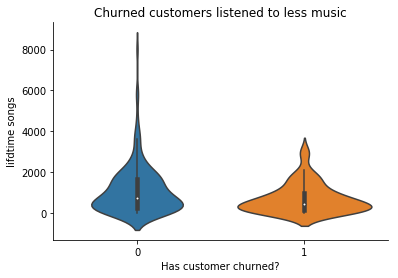

In [67]:
#提取NextSong数据，查看用户听歌数量的分布
lifetime_songs=df_valid.where('page=="NextSong"').groupby(['userId','churn']).count().toPandas()

#绘制小提琴图
ax=sns.violinplot(data=lifetime_songs,x='churn',y='count')
plt.xlabel('Has customer churned?')
plt.ylabel('lifdtime songs')
plt.title('Churned customers listened to less music')
sns.despine(ax=ax)

* 相比于非注销用户，注销用户听歌的数量较少，且数量的分布相对集中，其小提琴图形相对扁平

#### 2.2.2是否注销与单次听歌数量关系

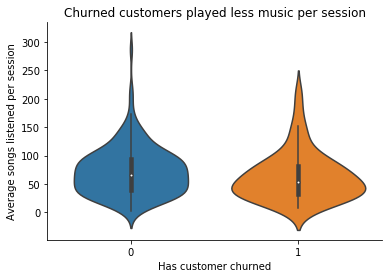

In [68]:
#提取NextSong数据，观察同一sessionId下听歌的平均数量的分布
avg_songs_listened=df_valid.where('page=="NextSong"').groupby(['churn', 'userId' ,'sessionId']).count().groupby(['churn','userId']).agg({'count':'avg'}).toPandas()

#绘制小提琴图
ax=sns.violinplot('churn',y='avg(count)',data=avg_songs_listened)
plt.xlabel('Has customer churned')
plt.ylabel('Average songs listened per session')
plt.title('Churned customers played less music per session' )
sns.despine(ax=ax)

* 相比于非注销用户，大部分注销用户同一sessionId下听歌的数量较少

#### 2.2.3是否注销与用户点赞量关系

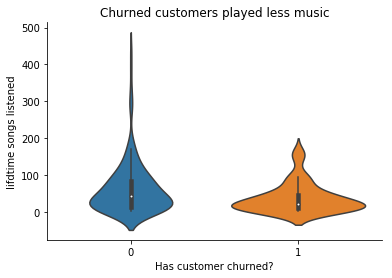

In [69]:
#提取humbs Up数据，观察用户点赞数量分布
a=df_valid.where('page=="Thumbs Up"').groupby(['userId','churn']).count().toPandas()

ax=sns.violinplot(data=a,x='churn',y='count')
plt.xlabel('Has customer churned?')
plt.ylabel('lifdtime songs listened')
plt.title('Churned customers played less music')
sns.despine(ax=ax)

* 相比于非注销用户，注销用户点赞的数量较少，且数量的分布相对集中

#### 2.2.4是否注销与性别关系

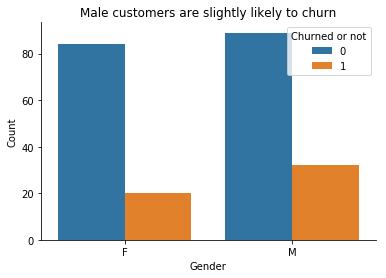

In [70]:
#提取性别与用户ID列，观察注销与性别间关系
gender_churn=df_valid.dropDuplicates(["userId","gender"]).groupby(["churn","gender"]).count().toPandas()

#绘制直方图
ax=sns.barplot(x='gender',y='count',hue='churn',data=gender_churn)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churned or not',loc='best')
plt.title('Male customers are slightly likely to churn')
sns.despine(ax=ax)

* 男性用户注销账户的绝对人数以及比例均比女性大

#### 2.2.5是否注销与用户存留天数关系

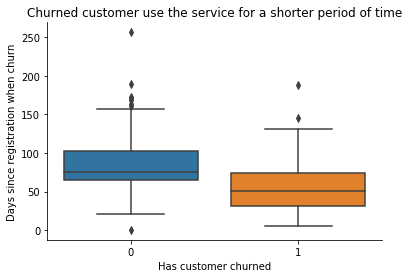

In [72]:
user_lifetime=df_valid.select('userId','registration','ts','churn').withColumn('lifetime',(df_valid.ts-df_valid.registration)).groupBy('userId','churn').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId','churn',(col('lifetime')/1000/3600/24).alias('lifetime')).toPandas()                                                                                                                                  

ax=sns.boxplot(data=user_lifetime,x='churn',y='lifetime') 
plt.xlabel('Has customer churned')
plt.ylabel('Days since registration when churn')
plt.title('Churned customer use the service for a shorter period of time')
sns.despine(ax=ax)

* 注销用户的存留天数更少

# 3特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 5.1构建变量

结合经验及以上的分析，构建以下变量：
* 用户听歌数量：听歌数量越大，说明用户愿意使用该服务，注销几率越小。以上绘图分析也显示：注销用户听歌数量较未注销的少
* 用户单次（同一sessionId）听歌平均数量：单次听歌数量越大，说明用户愿意使用该服务，注销几率越小。以上绘图分析也显示：注销用户单次听歌平均数量较未注销的少
* 点赞量：点赞越多，说明用户喜欢该服务，注销几率越小。以上绘图分析也显示：注销用户点赞数量较未注销的少
* 差评量：逻辑与点赞量恰好相反
* 添加播放列表量：用户将歌曲加进播放列表，一般可说明用户喜欢该音乐；添加的量越多，用户愿意使用该服务的可能性越大，注销可能性越小。
* 添加好友量：添加好友量越多，说明用于越愿意在改服务中交友分享，注销几率越小。
* 歌曲时长总量：听歌时长越长，说明用户倾向于使用该服务，注销几率越小。
* 播放的歌手数量：播放过的歌手数量越多，侧面说明用户听歌越多，越愿意使用该服务，注销几率越小。
* 性别：以上绘图分析显示：男性用户注销的数量较女性多。推测是改服务更能吸引女性
* 用户存留天数：一般来说，服务越吸引了用户，则用户存留越久，注销几率越小。以上绘图分析也显示：注销用户存留天数较未注销的短

In [73]:
#用户存留天数
#用注册时间与动作发生时间相减，并取出最长的时间，便是用户存留天数
f1=df_valid.select('userId','registration','ts').withColumn('lifetime',(df_valid.ts-df_valid.registration)).groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId',(col('lifetime')/1000/3600/24).alias('lifetime'))
f1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [74]:
#用户听歌数量
#获取每个用户听过歌曲的歌名信息计数，获得用户听歌数量
f2=df_valid.select('userID','song').groupBy('userID').count().withColumnRenamed('count','total_songs')
f2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [75]:
#点赞量
#获取每个用户点击页面Thumbs Up的数量信息计数，可获得用户点赞量
f3=df_valid.select('userID','page').where(df_valid.page=='Thumbs Up').groupBy('userID').count().withColumnRenamed('count','num_thumb_up')
f3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [76]:
#差评量
#获取每个用户点击页面Thumbs Down的数量信息计数，可获得用户差评量
f4=df_valid.select('userId','page').where(df_valid.page=='Thumbs Down').groupBy('userId').count().withColumnRenamed('count','num_thumb_down')
f4.describe().show()

+-------+------------------+------------------+
|summary|            userId|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [77]:
#添加进播放列表量
#获取每个用户点击页面Add to Playlist的数量信息计数，可获得用户添加进播放列表数量
f5=df_valid.select('userID','page').where(df_valid.page=='Add to Playlist').groupBy('userID').count().withColumnRenamed('count','add_to_playlist')
f5.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [78]:
#添加好友量
#获取每个用户点击页面Add Friend的数量信息计数，可获得用户添加好友书量
f6=df_valid.select('userID','page').where(df_valid.page=='Add Friend').groupBy('userID').count().withColumnRenamed('count','add_friend')
f6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [79]:
#歌曲时长总量
#每个用户播放时长累加
f7=df_valid.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)','listen_time')
f7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [80]:
#用户单次（同一sessionId）听歌平均数量
#获取每个sessionId点击页面NextSong数量信息并计数，并按用户求均值，可获得用户单次（同一sessionId）听歌平均数量
f8=df_valid.where('page=="NextSong"').groupBy('userId','sessionId').count().groupBy(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)','avg_songs_played')
f8.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [81]:
#性别
#取gender列，把F、M变量转为0、1，方便模型计算
f9=df_valid.select("userId","gender").dropDuplicates().replace(['paid','free'],['0','1'],'gender').select('userId',col('gender').cast('int'))
f9.describe().show()

+-------+------------------+------+
|summary|            userId|gender|
+-------+------------------+------+
|  count|               225|     0|
|   mean|65391.013333333336|  null|
| stddev|105396.47791907165|  null|
|    min|                10|  null|
|    max|                99|  null|
+-------+------------------+------+



In [82]:
#播放的歌手数量
#获取每个用户点击页面NextSong时的artist信息并计数，可获得用户听过的歌手数量
f10=df_valid.filter(df_valid.page=="NextSong").select("userID","artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count","artist_count")
f10.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [83]:
#标签
label=df_valid.select('userId',col('churn').alias('label')).dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



### 5.2变量聚合

In [84]:
#汇总特征数据与标签
data=f1.join(f2,'userID','outer')\
    .join(f3,'userID','outer')\
    .join(f4,'userID','outer')\
    .join(f5,'userID','outer')\
    .join(f6,'userID','outer')\
    .join(f7,'userID','outer')\
    .join(f8,'userID','outer')\
    .join(f9,'userID','outer')\
    .join(f10,'userID','outer')\
    .join(label,'userID','outer')\
    .drop('userID')\
    .fillna(0)
data.show(5)

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|  55.6436574074074|        381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     0|         252|    0|
| 70.07462962962963|        474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|         339|    0|
| 71.31688657407408|         11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|           8|    1|
|131.55591435185184|       4825|         171|            41|            118|        74|1

# 4建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

### 4.1准备数据

In [85]:
#用VectorAssembler将数据集转换为可供模型计算的结构（向量形式）
cols=["lifetime","total_songs","num_thumb_up","num_thumb_down","add_to_playlist","add_friend","listen_time","avg_songs_played","gender","artist_count"]
assembler=VectorAssembler(inputCols=cols,outputCol="NumFeatures")#
data=assembler.transform(data)#转成向量
data.show()

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+--------------------+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|         NumFeatures|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+--------------------+
|  55.6436574074074|        381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     0|         252|    0|[55.6436574074074...|
| 70.07462962962963|        474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|         339|    0|[70.0746296296296...|
| 71.31688657407408|         11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|   

In [86]:
#用StandardScaler标准化数据
scaler=StandardScaler(inputCol="NumFeatures",outputCol="features",withStd=True)
scalerModel=scaler.fit(data)
data=scalerModel.transform(data)

In [87]:
#拆分为训练集、测试集和验证集
train,validation,test=data.randomSplit([0.6,0.2,0.2],seed=42)

### 4.2模型选择

#### 4.2.1模型选择思路

* 以全0/全1预测作为基线，机器学习算法的分数应该比全0/全1预测更高
* 选用逻辑回归、支持向量机、随机森林进行对比，这几个模型一般不需要很多参数调整就可以达到不错的效果。他们的优缺点如下：
  * 1、逻辑回归：优点：计算速度快，容易理解；缺点：容易产生欠拟合
  * 2、支持向量机：数据量较小情况下解决机器学习问题，可以解决非线性问题。缺点：对缺失数据敏感
  * 3、随机森林：优点：有抗过拟合能力。通过平均决策树，降低过拟合的风险性。缺点：大量的树结构会占用大量的空间和利用大量时间

#### 4.2.2Baseline Model（全1/全0）

In [88]:
#对测试集进行预测，预测全为1
results_base_all_1=test.withColumn('prediction',lit(1.0))#'prediction列全是1
evaluator=MulticlassClassificationEvaluator(predictionCol='prediction')
print('Test set metrics')
print('Accuracy:{}'.format(evaluator.evaluate(results_base_all_1,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_1,{evaluator.metricName:"f1"})))

Test set metrics
Accuracy:0.29411764705882354
F-1 Score:0.1336898395721925


In [89]:
#对测试集进行预测，预测全为0
results_base_all_0=test.withColumn('prediction',lit(0.0))#'prediction列全是0
evaluator=MulticlassClassificationEvaluator(predictionCol='prediction')
print('Test set metrics')
print('Accuracy:{}'.format(evaluator.evaluate(results_base_all_0,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_0,{evaluator.metricName:"f1"})))

Test set metrics
Accuracy:0.7058823529411765
F-1 Score:0.5841784989858012


#### 4.2.3LogisticRegression

In [90]:
#创建并训练模型，通过time()记录训练时间
lr=LogisticRegression(maxIter=10)#初始化
start=time()#开始时间
model_lr=lr.fit(train)#训练
end=time()#结束时间
print('The training process took{} second'.format(end-start))

The training process took91.51399517059326 second


In [91]:
#验证模型效果
results_lr=model_lr.transform(validation)#验证集上预测
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#评分器
print('Logistic Regreession Metrics:')
print('Accuracy:{}'.format(evaluator.evaluate(results_lr,{evaluator.metricName:"accuracy"})))#计算Accuracy
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr,{evaluator.metricName:"f1"})))#计算F-1 Score

Logistic Regreession Metrics:
Accuracy:0.7959183673469388
F-1 Score:0.7871315192743764


#### 4.2.4LinearSVC

In [92]:
#创建并训练模型
svm=LinearSVC(maxIter=10)
start=time()
model_svm=svm.fit(train)
end=time()
print('The training process took{} second'.format(end-start))

The training process took174.3555302619934 second


In [93]:
#验证模型效果
results_svm=model_svm.transform(validation)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#
print('LinearSVC Metrics:')
print('Accuracy:{}'.format(evaluator.evaluate(results_svm,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm,{evaluator.metricName:"f1"})))

LinearSVC Metrics:
Accuracy:0.7959183673469388
F-1 Score:0.7054730983302412


#### 4.2.5Random Forest

In [39]:
#创建并训练模型，通过time()记录训练时间
rf=RandomForestClassifier()#初始化
start=time()#开始时间
model_rf=rf.fit(train)#训练
end=time()#结束时间
print('The training process took{} second'.format(end-start))

The training process took177.97566843032837 second


In [40]:
#验证模型效果
results_rf=model_rf.transform(validation)#验证集上预测
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#评分器
print('Random Forest Metrics:')
print('Accuracy:{}'.format(evaluator.evaluate(results_rf,{evaluator.metricName:"accuracy"})))#计算Accuracy
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf,{evaluator.metricName:"f1"})))#计算F-1 Score

Logistic Regreession Metrics:
Accuracy:0.8163265306122449
F-1 Score:0.7912466191295796


#### 4.2.6模型总结

* LogisticRegression模型：Accuracy为0.7959；F-1 Score为0.7871；耗时87s
* LinearSVC模型：Accuracy为0.7959；F-1 Score为0.7054；耗时170s
* Random Forest模型：Accuracy0.8163；F-1 Score0.7912；耗时150s

Random Forest的Accuracy及F-1 Score均最高，LogisticRegression耗时最小。考虑到Random Forest的训练耗时与LogisticRegression的训练耗时整体来说相差并非十分大，而我们希望获得效果更好的模型，故选用Random Forest模型，并通过调节模型参数获取更优模型

### 4.3模型调优

* 如上所述，选用Random Forest进行调优
* 因为流失顾客数据集很小，Accuracy很难反映模型好坏，根据建议选用 F1 score 作为优化指标。
* 使用3折交叉验证及参数网络对模型进行调优

In [45]:
#创建模型
rf=RandomForestClassifier()
f1_evaluator=MulticlassClassificationEvaluator(metricName='f1')

paramGrid=ParamGridBuilder().addGrid(rf.maxDepth,[3,5]).addGrid(rf.numTrees,[20,50]).build()

crossval_rf=CrossValidator(estimator=rf,
        estimatorParamMaps=paramGrid,
        evaluator=f1_evaluator,
        numFolds=3)

In [46]:
#训练并获取最佳参数
cvModel_rf=crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.7410024630805638,
 0.7646356353673427,
 0.7624867561386672,
 0.7574763669177517]

In [47]:
#验证调优后效果
results_rf_cv=cvModel_rf.transform(validation)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print('Crossval Random Forest Metrics:')
print('Accuracy:{}'.format(evaluator.evaluate(results_rf_cv,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf_cv,{evaluator.metricName:"f1"})))

Crossval Random Forest Metrics:
Accuracy:0.8163265306122449
F-1 Score:0.7912466191295796


* 对比调优前后的模型在验证集上预测结果，调优前Accuracy0.8163；F-1 Score0.7912；调优后Accuracy为0.8235，F-1 Score为0.796，分别提升了XXX%及XXX%。

### 4.4使用最佳模型预测

In [48]:
#使用未优化模型预测
results_final=model_rf.transform(test)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metricd:')
print('Accuracy:{}'.format(evaluator.evaluate(results_final,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final,{evaluator.metricName:"f1"})))

Test set metricd:
Accuracy:0.8235294117647058
F-1 Score:0.8082579185520363


In [49]:
#使用最佳模型预测
results_final_best=cvModel_rf.transform(test)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metricd:')
print('Accuracy:{}'.format(evaluator.evaluate(results_final_best,{evaluator.metricName:"accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final_best,{evaluator.metricName:"f1"})))

Test set metricd:
Accuracy:0.8529411764705882
F-1 Score:0.8353681095079541


* 使用交叉验证和参数网络搜索调优随机森林的参数，对测试集进行预测。预测结果Accuracy为0.8235，F-1 Score为0.796，相比基线模型（Accuracy:0.7059；F-1 Score:0.584）分别有XXX%及XXX%提升。

# 5总结

### 5.1总结&反思

* 过程总结
    * 这个项目中，我们建立了一个预测流失用户的模型。
    * 在数据集中，我们删除了没有用户ID的数据，将时间戳转为人们可读的格式；此外对流失用户建立了标识，并结合对特征与是否流失间关系的探索，并建立了10个特征
    * 然后我们选择3个模型：逻辑回归，SVM和随机森林进行比较。根据比较结果。选择了随机森林预测最后结果。
    * 接着我们使用交叉验证和参数网络搜索调优随机森林的参数，对测试集进行预测。预测结果Accuracy为0.8235，F-1 Score为0.796，相比基线模型（Accuracy:0.7059；F-1 Score:0.584）分别有XXX%及XXX%提升。

* 过程反思
    * 构建合适的特征对于建立好的模型十分重要。而数据集中，现成的可用于预测的特征并不多；我们需要重新构造特征来预测流失用户。而从数据集中构造变量一方面需要经验与知识的积累，一方面需要熟悉手上的数据
    * 对比各未经优化的模型间Accuracy及F-1 Score，对于Accuracy各模型相差不大，LogisticRegression及Random Forest的F-1 Score相近。后续想有较大幅度提升，可能需要进一步优化特征选取

* （暂时不用，后续删除）
虽然最终采用逻辑回归作为最终模型是因为其accuracy与f1分数最高，但我认为分数还有进一步提高的可能，有这种想法主要因为以下几点：

第一次运算时SVM与逻辑回归分数一样，一般上讲逻辑回归容易欠拟合，但和SVM模型结果一样，说明逻辑回归欠拟合的可能性较小；
三种模型的f1分数并不高，说明pricision和recall始终不平衡；
最佳逻辑回归模型代入测试集运算后，accuracy与f1均下降了3%左右，并没有与之前差很多。
综合以上观点，我认为在特征工程部分出现了偏差导致这种现象，我选择的特征与用户流失率的关系不是特别相关。在后续完善工作中，我认为以下方案可以提高accuracy与f1分数：

增加参考标准，计算没有用户流失和全部用户流失的accuracy与f1分数，评估其他模型好坏；
回顾数据集，对未理解的特征进行探究，了解其含义，找到与数据集相关性更强的特征；
增加决策树、梯度提升树等其他算法，对比已使用的算法，观察accuracy与f1分数变化。
在完成项目的过程中遇到以下难点，思考其解决方案时间较久，不过最终都解决了：

每次运行模型，分数总会变化。造成该问题的主要原因是每次被分割的数据集均在变化，每次关掉IDE，变量就会被清空，重新加载运行，必然重新分割数据集；
开始将会员是否付费作为特征，代入模型计算，但分数较现在更低，思考后，感觉该特征和用户流失率并无因果关系，删去此特征后，accuracy与f1分数均有提高。

### 5.3改进

1、数据量方面：相对原始数据而言，这个只是一个相对较小的数据集。如果增加数据量，可以得到预测效果更好的模型

2、特征方面：用于预测流失用户的特征进一步增加完善，找到与数据集相关性更强的特征，以提升模型性能。如增加用户注销账户时的的等级作为特征；或者对未理解未探索的特征进一步研究

3、模型方面：选用决策树、梯度提升树等其他算法，对比已使用的算法，观察accuracy与f1分数变化

# 6最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。